# SnapChat Filters : FaceSwap

# Overview

Snapchat filters or "*lenses*" as it is called, can be broadly put into three categories. 

1. Augmenting the face with different things like beard, glasses, vampire-teeths, rabbit-ears, dog-nose, flower-band on the forehead etc.

2. Removing parts of the face and inserting different things another face ( faceswap ), removing the eyes and inserting bug eyes etc.

3. Deforming the face to create funny looking pictures like frowning or sad face, squeezing the chin, elongating the forehead etc.

The first two can be implemented using the techniques we have learned so far and a few more that we will learn in this module. We saw an example of the third type in last week’s bug-eyes lecture. This week, we will see more examples of deforming the face using a deformation technique called Moving Least Squares in the next modules.

# FaceSwap

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-faceSwapPresident.
"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-faceSwapPresident.png"/></a></center>
<center>Figure 1 : Face Swapped Presidential Candidates</center>

&nbsp;
**In this lecture, we will learn how to perform Face swapping i.e. swap out a face in one image with a completely different face. We will be using concepts from week 3 and week 4 in this module. Please complete them before starting this module.**

## Why is Face-Swap difficult ?

The human brain treats human faces as a special category and has specialized machinery to process faces. We are very good at analyzing faces and can easily detect a fake face. It is easy to computationally replace a face in one image with a different face if you want to do it for giggles, but extremely difficult to do if you want to do it completely automatically at a quality that will fool people consistently. After all, we are trying to fool one of the most advanced cognitive machinery in the human brain.

Checkout how Snapchat’s faceswap filter went wrong on some occasions and created some buzz [here](https://www.buzzfeed.com/genamourbarrett/snapchats-that-prove-face-swap-is-the-most-terrifying-upd?utm_term=.iyg3dDkpq#.uu5BEo7DO) and [here](http://www.boredpanda.com/funny-snapchat-face-swaps/). 

Consider the images of top three presidential candidates of the 2016 US elections in Figure 2.

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-originalPresidentFace.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-originalPresidentFace.png"/></a></center>

<center>Figure 2 : Original Image of Presidential Candidates</center>

&nbsp;
The three images are pretty different. 

First, the facial geometry of the three people varies quite a bit. Second, the lighting on the face combined with the tone of the skin can make the images look very different. Third, the pose of the face ( or camera angle if you will ) can vary significantly. And finally, the texture of the skin can vary from smooth to rough.

We will address the first two problems but not the last two.

# FaceSwap : Step by Step

## 1. Face Alignment

To replace one face with another, we first need to place one face approximately on top of the other so that it covers the face below. An example is shown in Figure 3.

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opv4face-w5-m2-faceAlignment.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opv4face-w5-m2-faceAlignment.png"/></a></center>

Figure 3. Face Alignment. Left : Detected facial landmarks and convex hull. Middle : Delaunay triangulation of points on convex hull. Right : Face alignment by affine warping triangles.

### Facial Landmark Detection

The geometry of the two faces are very different and so we need to warp the source face so that it covers the target face, but we also want to make sure we do not warp it beyond recognition. To achieve this we first detect facial landmarks on both images using Dlib. However, unlike in Face Morphing, we do not and should not use all the points for face alignment. We simply need the points on the outer boundary of the face as shown in the image. We also take 12 points around the mouth for better alignment.

## 2. Find Convex Hull 

In Computer Vision and Math jargon, the boundary of a collection of points or shape is called a "hull". A boundary that does not have any concavities is called a “Convex Hull”. In Figure 3. the image on the left shows facial landmarks detected using dlib in red and the convex hull of the points is shown in blue. The convex hull of a set of points can be calculated using OpenCV’s [convexHull](https://docs.opencv.org/4.1.0/d3/dc0/group__imgproc__shape.html#ga014b28e56cb8854c0de4a211cb2be656) function.

### Function Syntax

```python
hull	=	cv2.convexHull(	points[, hull[, clockwise[, returnPoints]]]	)
```

Where,

- **`points`** - Input 2D point set.
- **`hull`** - Output convex hull. It is either an integer vector of indices or vector of points. In the first case, the hull elements are 0-based indices of the convex hull points in the original array (since the set of convex hull points is a subset of the original point set). In the second case, hull elements are the convex hull points themselves.
- **`clockwise`** - Orientation flag. If it is true, the output convex hull is oriented clockwise. Otherwise, it is oriented counter-clockwise. The assumed coordinate system has its X axis pointing to the right, and its Y axis pointing upwards.
- **`returnPoints`** - Operation flag. In case of a matrix, when the flag is true, the function returns convex hull points. Otherwise, it returns indices of the convex hull points.


## 3. Delaunay Triangulation

The next step in alignment is to do a Delaunay triangulation of the points on the convex hull. The triangulation is shown in the middle image in Figure 3. This allows us to divide the face into smaller parts. We had covered delaunay triangulation in detail in the previous week.

## 4. Affine warp triangles 

The final steps of face alignment is to consider corresponding triangles between the source face and the target face, and affine warp the source face triangle onto the target face. We had covered warping of triangles in the previous week. However, as you can see in the right image of Figure 3, aligning the face and slapping one face on top of the other hardly looks natural. The seams are visible because of lighting and skin tone differences between the two images. The next step shows how to seamlessly combine the two images.

## 5. Blending of images

The difference in lighting and skin tone between the source and destination images makes the warped image look unnatural. For rectifying this, we take two different routes for images and videos. This is because the method used for images is pretty slow and cannot be applied to videos as it will bring down the FPS drastically. The two methods are discussed below.

### Seamless Cloning

Good technical ideas are like good magic. Good magicians use a combination of physics, psychology and good old sleight of hand to achieve the incredible. Image warping alone looks pretty bad. Combine it with Seamless Cloning and the results are magical! 

It is a feature in OpenCV 3 that allows you to seamlessly clone parts of the source image ( identified by a mask ) onto a destination image.

### Function Syntax

```python
blend	=	cv2.seamlessClone(	src, dst, mask, p, flags[, blend]	)
```

Where, 

- **`src`** - Input 8-bit 3-channel image.
- **`dst`** - Input 8-bit 3-channel image.
- **`mask`** - Input 8-bit 1 or 3-channel image.
- **`p`** - Point in dst image where object is placed.
- **`blend`** - Output image with the same size and type as dst.
- **`flags`** - Cloning method that could be cv2.NORMAL_CLONE, cv2.MIXED_CLONE or cv2.MONOCHROME_TRANSFER


<center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-seamleessCloning.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-seamleessCloning.png"/></a></center>

&nbsp;
The src image in the above usage is the shown in Figure 3. ( Right ). The dst image is image onto which we want to blend the source image (i.e. the image of Donald Trump ). The mask is calculated by filling the convex hull with white using fillConvexPoly and the center is the center of the bounding box that contains the mask.


### Code and Tutorial for Image based Face swap

In [2]:
import dlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
import faceBlendCommon as fbc
from dataPath import DATA_PATH
import time
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

In [4]:
# Initialize the dlib facial landmark detector variables
modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat"

# initialize the dlib facial landmakr detector
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(modelPath)

Setup a timer to calculate the total time taken for running the program.

In [5]:
t = time.time()

Read the files and find the landmark points on the face using dlib.

In [6]:
# Read images
filename1 = DATA_PATH + 'images/ted_cruz.jpg'
filename2 = DATA_PATH + 'images/donald_trump.jpg'

img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)
img1Warped = np.copy(img2)   

# Read array of corresponding points
points1 = fbc.getLandmarks(detector, predictor, img1)
points2 = fbc.getLandmarks(detector, predictor, img2)

Create convex hulls to find the region on the faces to be swapped.



In [7]:
# Find convex hull
hull1 = []
hull2 = []

hullIndex = cv2.convexHull(np.array(points2), returnPoints=False)

for i in range(0, len(hullIndex)):
    hull1.append(points1[hullIndex[i][0]])
    hull2.append(points2[hullIndex[i][0]])

Calculate the delaunay triangles using the points of the second image.

In [8]:
# Find delanauy traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])

dt = fbc.calculateDelaunayTriangles(rect, hull2)

if len(dt) == 0:
    print("No delanauy triangles calculated")

Warp the triangles created using delaunay triangulation from the source image to the destination image.



In [9]:
# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []

    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])

    fbc.warpTriangle(img1, img1Warped, t1, t2)

| <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-warpingStage1.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-warpingStage1.jpg"/></a></center> |  <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-delaunyStage2.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-delaunyStage2.jpg"/></a></center> | <center> <a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-delaunystage3.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m2-delaunystage3.jpg"/></a></center> |
| -------- | -------- | -------- |

<center>Showing different stages of warping the delaunay triangles</center>

Print the time taken and setup a timer for seamless cloning

In [10]:
print("Time taken for faceswap {:.3f} seconds".format(time.time()
    - t))
tClone = time.time()

Time taken for faceswap 4.844 seconds


Seamless Cloning is done here.
First we create a mask around the face of the destination image using a convex hull. Then, find the center of this mask. This will be used in seamless cloning. Finally pass the source and destination image to the seamlessClone function to blend the warped image.

In [11]:
# Calculate Mask for Seamless cloning
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))

mask = np.zeros(img2.shape, dtype=img2.dtype)  

cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255));

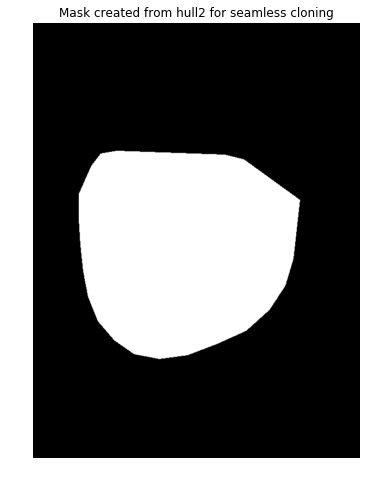

In [12]:
plt.imshow(mask)
plt.title("Mask created from hull2 for seamless cloning")
plt.axis('off')
plt.show()

In [13]:
# find center of the mask to be cloned with the destination image
r = cv2.boundingRect(np.float32([hull2]))    

center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))

# Clone seamlessly.
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, 
                          cv2.NORMAL_CLONE)

Print the time taken.
Display and save the faceswap output with and without seamless cloning.

In [14]:
print("Time taken for seamless cloning {:.3f} seconds".
      format(time.time() - tClone))

print("Total Time taken {:.3f} seconds ".format(time.time() - t))

Time taken for seamless cloning 9.065 seconds
Total Time taken 13.909 seconds 


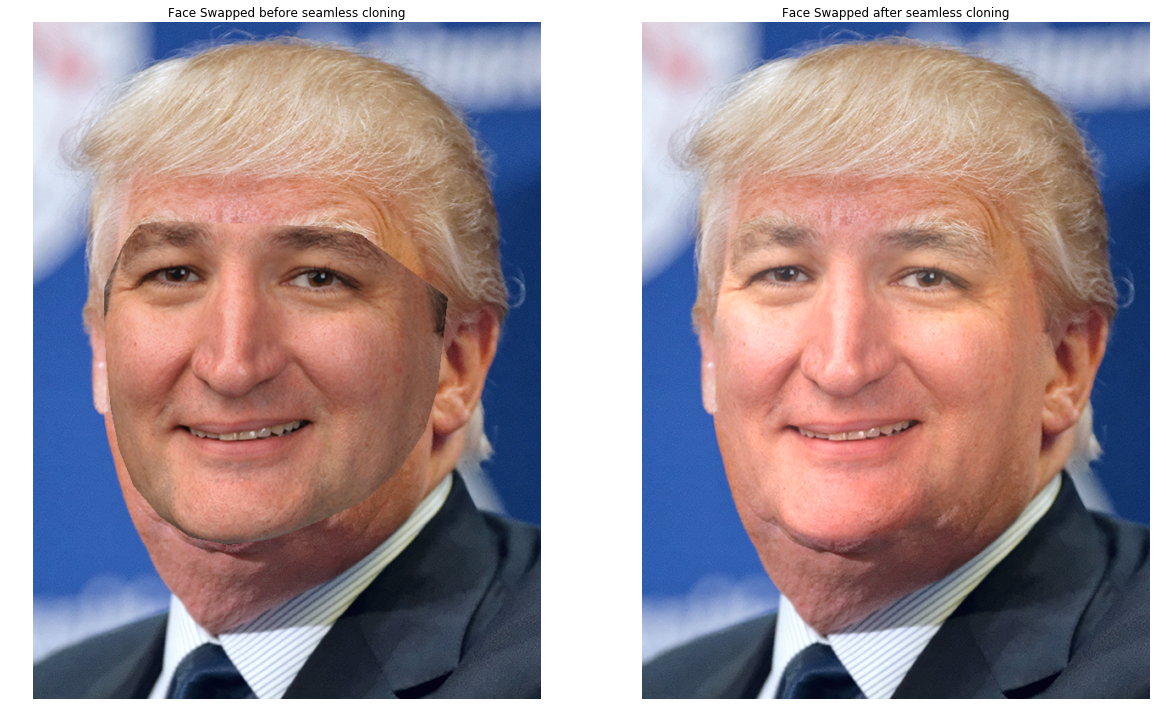

In [18]:
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(np.uint8(img1Warped)[:,:,::-1])
plt.title("Face Swapped before seamless cloning")
plt.axis('off')

plt.subplot(122)
plt.imshow(output[:,:,::-1])
plt.title("Face Swapped after seamless cloning")
plt.axis('off')

plt.show()




## References and Further Reading

1. [http://www.learnopencv.com/face-swap-using-opencv-c-python/](http://www.learnopencv.com/face-swap-using-opencv-c-python/)

2. [https://matthewearl.github.io/2015/07/28/switching-eds-with-python/](https://matthewearl.github.io/2015/07/28/switching-eds-with-python/)